In [2]:
import geopandas as gpd
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from scipy.stats import t

#segoe ui
plt.rcParams['font.family'] = 'Segoe UI'

#### Import bias corrected pickled data

In [3]:
src_isimip = r"D:\VUB\_data\_isimip_3b\bias_corrected"
be_shp = gpd.read_file(r"W:\VUB\_main_research\data\shapefiles\world_countries\10m_cultural\10m_cultural\be_joined_4326.shp")

src_EOBS = r'D:/VUB/_data/mHM_EOBS'
pr_EOBS = xr.open_dataset(f'{src_EOBS}/pre.nc')
tmax_EOBS = xr.open_dataset(f'{src_EOBS}/tmax.nc')
tmin_EOBS = xr.open_dataset(f'{src_EOBS}/tmin.nc')


#changes in temperature and precipitation per scenario
models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))
vars = ['pre', 'tmax', 'tmin', 'tavg']
scenarios = ['historical', 'ssp370', 'ssp585']


isimip_data = {}

#Open the datasets for each model and scenario
for model in models:
    for scenario in scenarios:
        for variable in vars:
            file_path = f"{src_isimip}/{model}/{scenario}/{model}_{variable}.nc"
            data = xr.open_dataset(file_path)
            name = f"{model}_{scenario}_{variable}"
            isimip_data[name] = data

#### Functions (to transfer)

In [4]:
#clip to region
from shapely.geometry import mapping
def clip_to_region(shapefile, xr_dataset):
    """
    This function clips an xarray dataset to a given shapefile.

    Parameters
    ----------
    shapefile : geopandas.GeoDataFrame
        The shapefile to clip the dataset to.
    xr_dataset : xarray.Dataset
        The dataset to clip.

    Returns
    -------
    xarray.Dataset
        The clipped dataset.
    """
        #set shapefile to crs 4326
    shapefile = shapefile.to_crs('epsg:4326')

    #drop bnds dimension
    xr_dataset = xr_dataset.drop_dims("bnds", errors="ignore")

    #set spatial dimensions
    xr_dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

    #write crs
    xr_dataset.rio.write_crs('epsg:4326', inplace=True)

    #clip
    clipped = xr_dataset.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)

    return clipped

#=================================================================

season_order = ['DJF','MAM','JJA','SON']

def seasonal_climatology(da, how, drop_incomplete=True):
    """
    Compute seasonal climatology for meteorological variables.

    Parameters
    ----------
    da : xarray.DataArray
        The data array to compute the seasonal climatology for.
    how : str
        The method to use for aggregation ('sum' or 'mean').
    drop_incomplete : bool
        Whether to drop incomplete seasons (default: True).

    Returns: 
    
    DataArray with dims ('season', lat, lon) ordered DJF,MAM,JJA,SON.
    """
    # 1) monthly aggregation
    if how == 'sum':
        mon = da.resample(time='ME').sum()
    elif how == 'mean':
        mon = da.resample(time='ME').mean()
    else:
        raise ValueError("how must be 'sum' or 'mean'")

    # 2) seasonal aggregation per year (quarters starting in Dec => DJF/MAM/JJA/SON)
    if how == 'sum':
        seas = mon.resample(time='QS-DEC').sum()
    else:  # mean
        seas = mon.resample(time='QS-DEC').mean()

    # 3) (optional) drop incomplete seasons (edge years with <3 months)
    if drop_incomplete:
        nmon = mon.notnull().resample(time='QS-DEC').sum()
        seas = seas.where(nmon >= 3)

    # 4) climatology across years and canonical season order
    clim = seas.groupby('time.season').mean('time')
    return clim.reindex(season=season_order)

def pr_seasonal_delta(fut_da, hist_da, percent=False, how='sum'):
    """
    Seasonal change (future − historical):
      - 'abs' in original units (mm/season if how='sum', °C if how='mean')
      - 'pct' as % change (only meaningful when historical > 0)
    """
    fut  = seasonal_climatology(fut_da,  how=how)
    hist = seasonal_climatology(hist_da, how=how)
    #fut, hist = xr.align(fut, hist, join='exact')  # enforce identical coords

    abs_change = fut - hist
    pct_change = xr.where(hist > 0, 100.0 * abs_change / hist, np.nan)
    if percent:
        return pct_change
    else:
        return abs_change


#=================

def plot_mmodel_delta_seasonal(meteo_dict, ssp_scenario, seasons):

    #subset data for specific SSP scenario
    ssp_dict= {}
    for key in meteo_dict:
        if ssp_scenario in key:
            ssp_dict[key] = meteo_dict[key]

    # extract color scale limits
    # v = max(float(np.nanmax(np.abs(da.values))) for da in ssp_dict.values())
    # vmin, vmax = -v, v

    ssp_dict = {key: meteo_dict[key] for key in meteo_dict if ssp_scenario in key}
    stack = xr.concat(list(ssp_dict.values()), dim='stack_for_scale')
    vmin = np.nanpercentile(stack, 1)
    vmax = np.nanpercentile(stack, 99)

    # create figure and axes
    fig, axes = plt.subplots(
        nrows=len(ssp_dict), ncols=len(seasons), figsize=(15, 20),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # plot data
    for i, (name, da) in enumerate(ssp_dict.items()):
        model = name.split('_')[0]
        for j, s in enumerate(seasons):
            ax = axes[i, j]
            be_shp.boundary.plot(ax=ax, linewidth=0.5, color='black', transform=ccrs.PlateCarree())
            im = da.sel(season=s).plot(
                ax=ax, cmap='seismic_r', add_colorbar=False,
                vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree()
            )
            if i == 0:
                ax.set_title(s, color='k')
            else:
                ax.set_title('')
            
            # add model label 
            if j == 0: ax.text(-0.05, 0.4, f"{model}", transform=ax.transAxes, ha='center', va='center', rotation=90, weight='bold', fontsize=12)

            gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
            gl.bottom_labels = True
            gl.top_labels   = False
            gl.left_labels  = False
            gl.right_labels = (j == len(seasons)-1)
            gl.bottom_labels= (i == len(meteo_dict)-1)
            if i == len(seasons):
                gl.bottom_labels = True
            gl.xlocator = mticker.FixedLocator(np.arange(0, 10, 1))
            gl.ylocator = mticker.FixedLocator(np.arange(49.5, 51.9, 0.4))
            gl.xlabel_style = {'size': 12, 'color': 'k'}
            gl.ylabel_style = {'size': 12, 'color': 'k'}

        axes[i, 0].set_ylabel(model)  # row label on leftmost plot

    # shared colorbar
    cax = fig.add_axes([0.02, 0.07, 0.95, 0.02]) #left, bottom, width, height
    cb = fig.colorbar(im, cax=cax, orientation='horizontal')
    

    plt.tight_layout(rect=[0, 0.08, 1, 1])

    return fig, cb


#### Historical Comparison of EOBS and bias-corrected ISIMIP

In [5]:
#### compare hist model to hist observed

hist_ISIMIP = {key: da for key, da in isimip_data.items() if 'historical_pre' in key}

#clip to region
hist_ISIMIP_BE = {}

#Clip and subset to overlapping period
hist_EOBS_BE = clip_to_region(be_shp, pr_EOBS.sel(time=slice('1971', '2014')))
seasonal_hist = seasonal_climatology(hist_EOBS_BE, how='sum')

#apply mask
seasonal_hist = seasonal_hist.where(seasonal_hist > 0.0001)

for key, da in hist_ISIMIP.items():
    data = clip_to_region(be_shp, da)
    hist_ISIMIP_BE[key] = data

    #seasonal climatology
    hist_mon_avg = seasonal_climatology(data, how='sum')

     #valid data where var in hist is not 0
    mask = data.where(data.var() > 0.0001).notnull().all(dim='time')
    hist_mon_avg = hist_mon_avg.where(mask)

    hist_ISIMIP_BE[key] = hist_mon_avg

In [6]:
hist_ISIMIP_BE.keys()

dict_keys(['GFDL-ESM4_historical_pre', 'IPSL-CM6A-LR_historical_pre', 'MPI-ESM1-2-HR_historical_pre', 'MRI-ESM2-0_historical_pre', 'UKESM1-0-LL_historical_pre'])

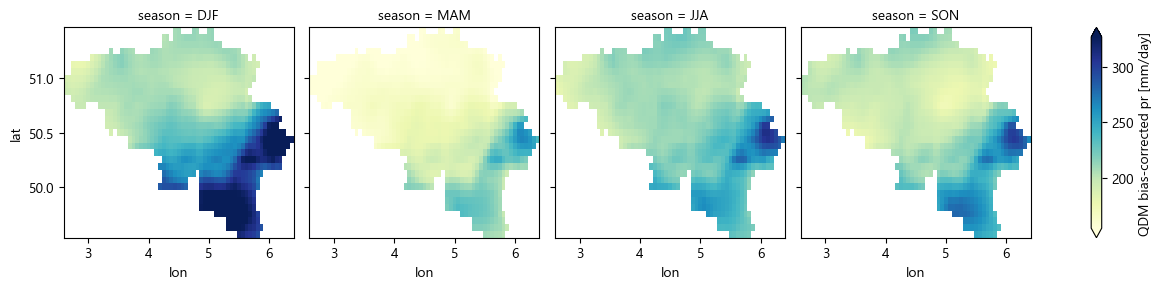

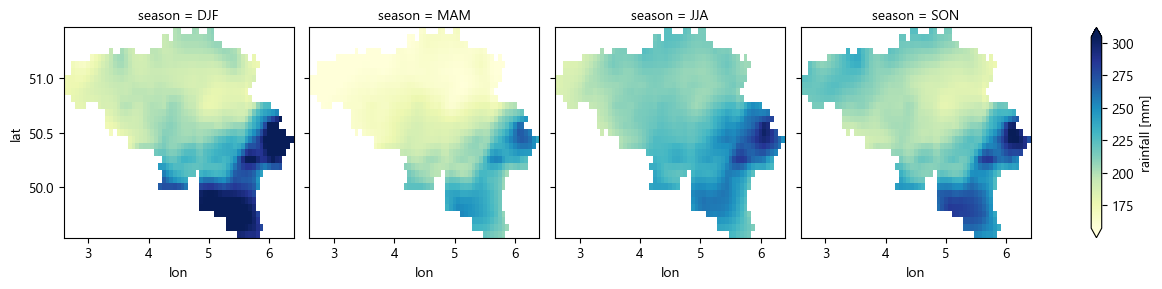

In [7]:
data = hist_ISIMIP_BE['UKESM1-0-LL_historical_pre']

data['pre'].plot(col='season', cmap='YlGnBu', robust=True)

#apply mask
seasonal_hist = seasonal_hist.where(seasonal_hist > 0.0001)
seasonal_hist['pre'].plot(col='season', label='EOBS', cmap='YlGnBu',robust=True)

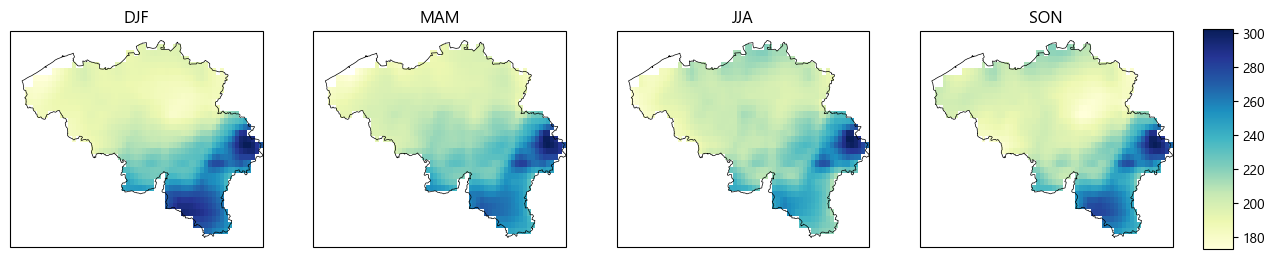

In [8]:
fig, axes = plt.subplots(
        nrows=1, ncols=4, figsize=(15, 20),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
ax=axes.flatten()

#plot data
seasons=['DJF','MAM','JJA','SON']
for i, s in enumerate(seasons):
    be_shp.boundary.plot(ax=ax[i], linewidth=0.5, color='black', transform=ccrs.PlateCarree())
    im = data['pre'].sel(season=s).plot(
        ax=ax[i], cmap='YlGnBu', add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    ax[i].set_title(s, color='k')
cax=fig.add_axes([0.92, 0.44, 0.02, 0.11], transform=ccrs.PlateCarree()) #left, bottom, width, height
cb=fig.colorbar(im, cax=cax, orientation='vertical')


#### Projected Changes in Precipitation

In [9]:
#changes in temperature and precipitation per scenario
models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))
var = ['pre', 'tasmax', 'tasmin']
model_scenarios = ['ssp370', 'ssp585']

#-----------------------------------------------------------
#define start and end of historical period
historical_period_start = '1981-01-01'
historical_period_end = '2010-12-31'

#define future period
future_period_start = '2071-01-01'
future_period_end = '2100-12-31'

delta_tmax_isimip_bc_QDM = {}
delta_tmin_isimip_bc_QDM = {}
delta_isimip_pr = {}

seasons = ['DJF', 'MAM', 'JJA', 'SON']

for model in models:
    hist_pr = clip_to_region(
        be_shp,
        isimip_data[f"{model}_historical_pre"].sel(time=slice(historical_period_start, historical_period_end)))['pre']  # <-- ensure DataArray
    
    for scenario in model_scenarios:
        fut_pr = clip_to_region(
            be_shp,
            isimip_data[f"{model}_{scenario}_pre"].sel(time=slice(future_period_start, future_period_end)))['pre']  # <-- ensure DataArray
        

        delta_ds = pr_seasonal_delta(fut_pr, hist_pr, percent=True, how='sum')  # Dataset with 'abs' and 'pct'

        #valid data where var in 
        mask = hist_pr.isel(time=0).notnull()
        delta_ds = delta_ds.where(mask)

        delta_isimip_pr[f"{model}_{scenario}_delta_pr"] = delta_ds  # or store delta_ds['abs'] if you only want absolute

#### Seasonal Plots per scenario

C:\Users\kart\AppData\Local\Temp\ipykernel_27592\4140464838.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 1])


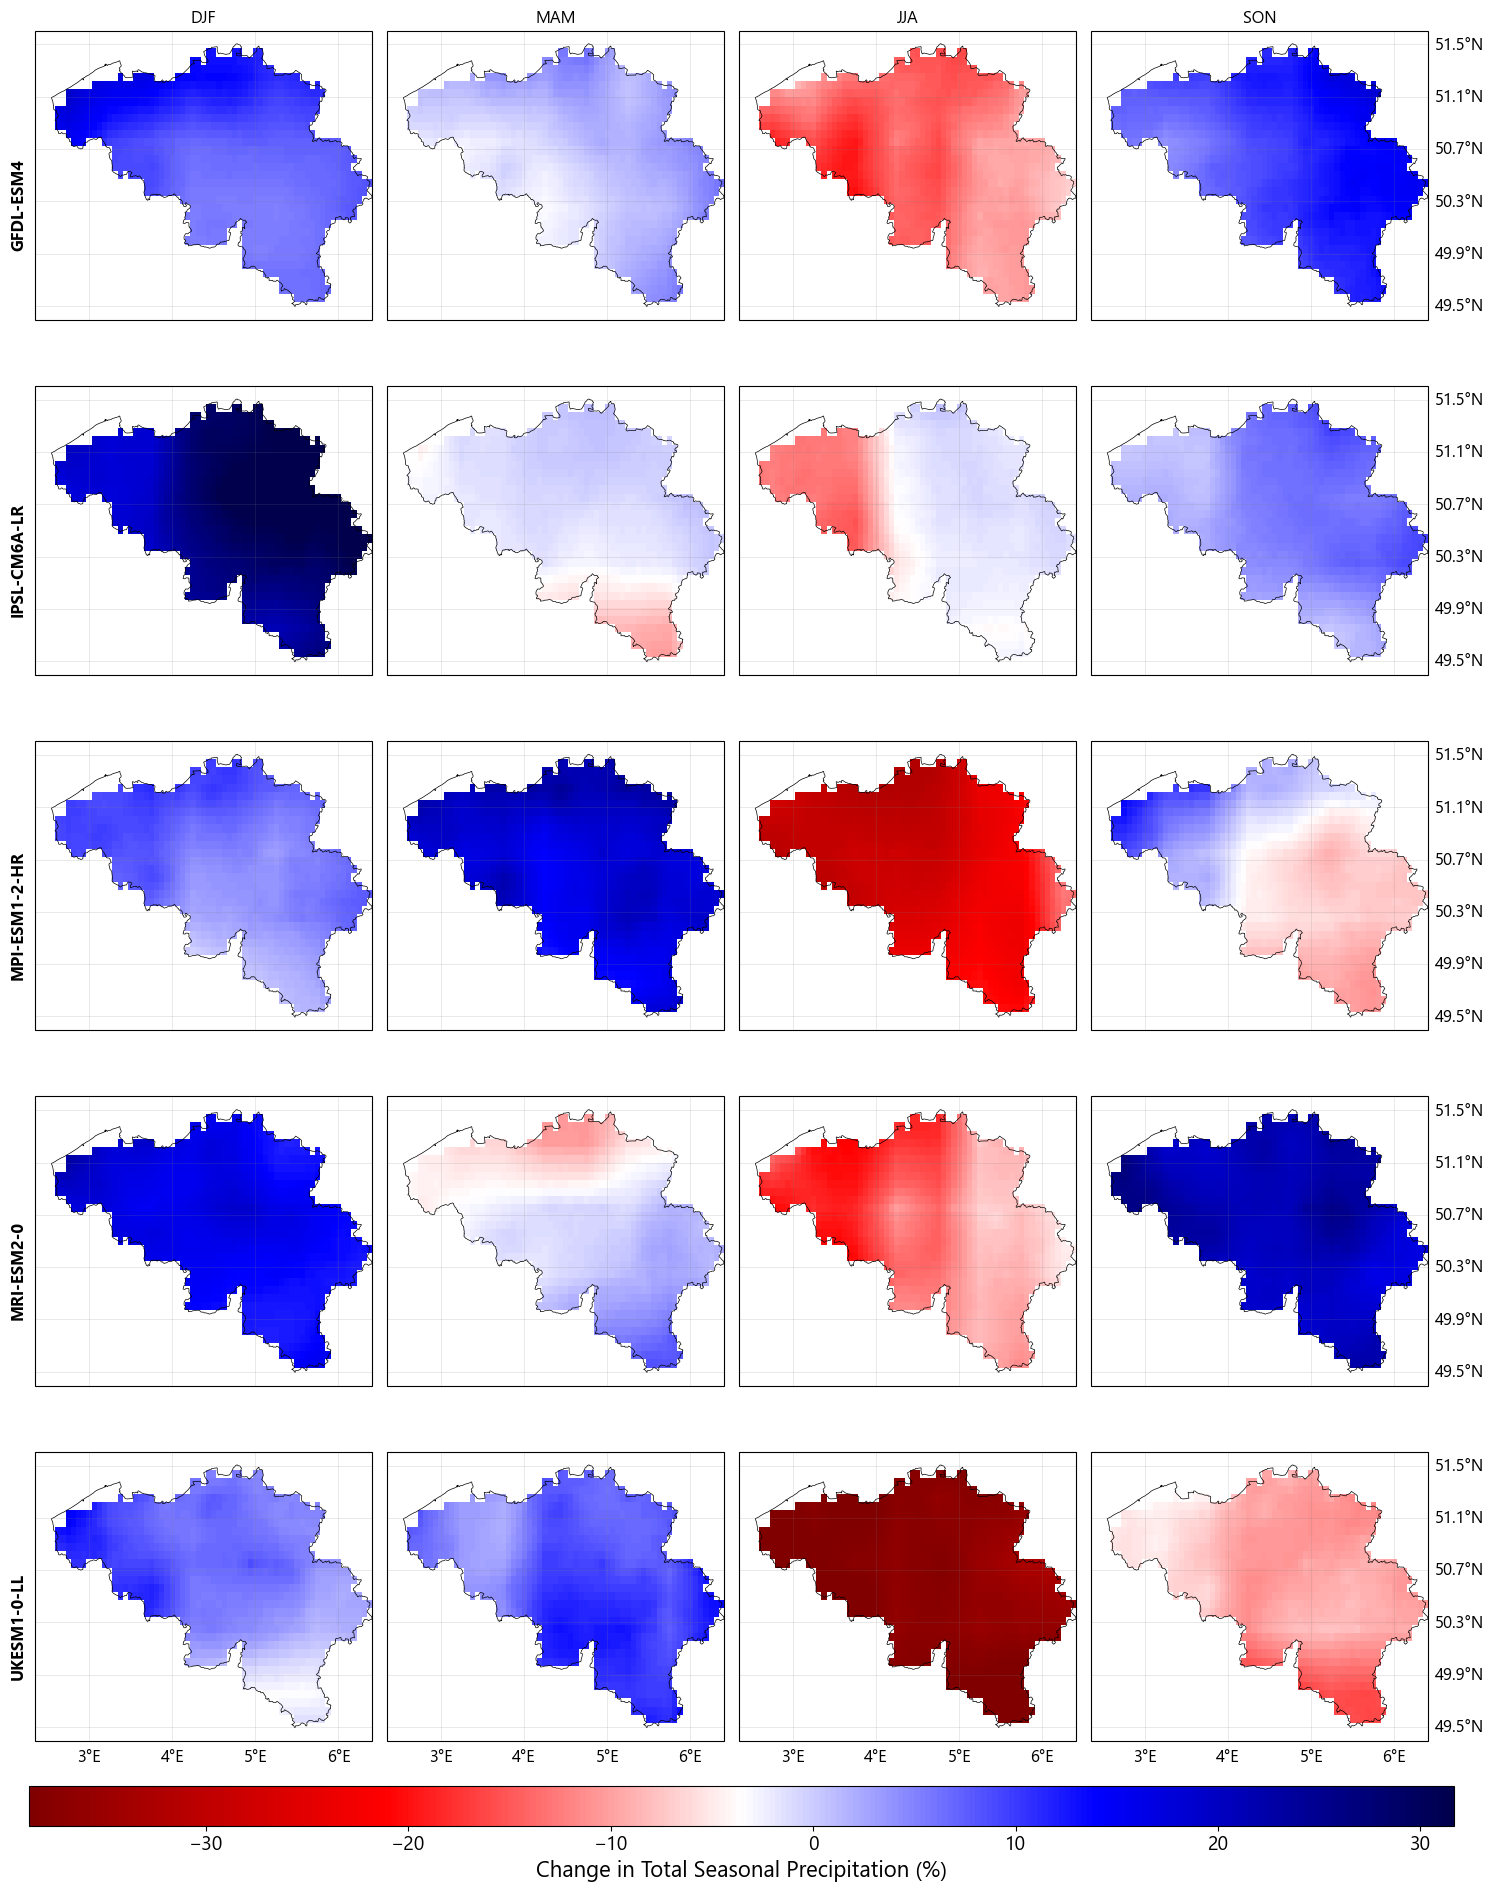

In [10]:
#Plot ssp 370
seasons = ['DJF','MAM','JJA','SON']
ssp_scenario= 'ssp370'

fig, cb = plot_mmodel_delta_seasonal(delta_isimip_pr, ssp_scenario=ssp_scenario, seasons=seasons)

cb.set_label('Change in Total Seasonal Precipitation (%)', fontsize=16)
cb.ax.tick_params(labelsize=14)

C:\Users\kart\AppData\Local\Temp\ipykernel_27592\4140464838.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 1])


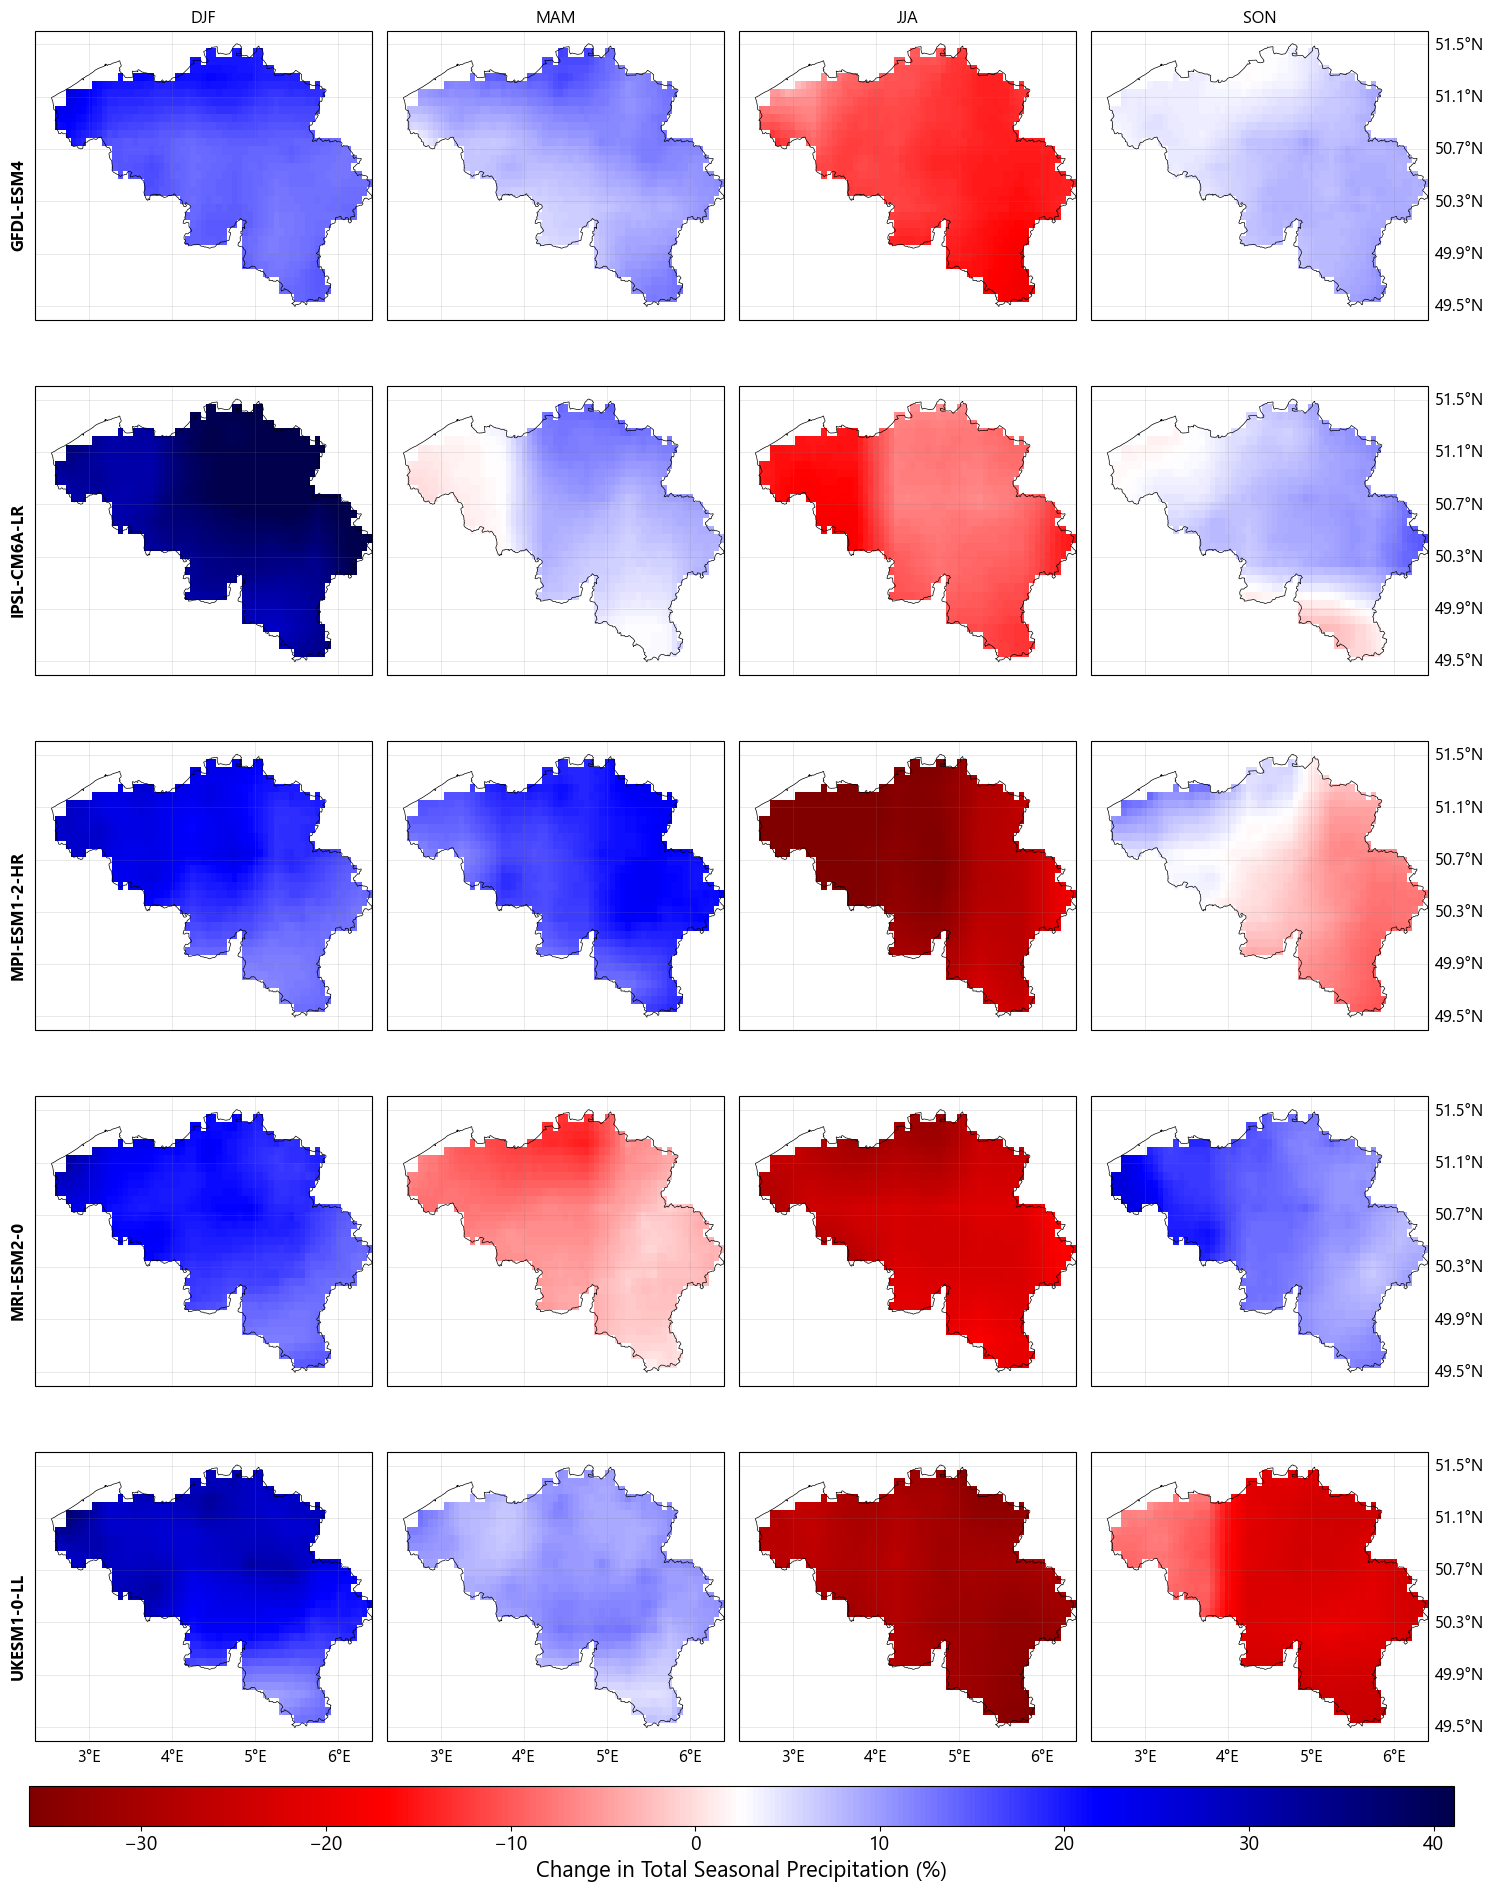

In [11]:
#Plot ssp 585
seasons = ['DJF','MAM','JJA','SON']
ssp_scenario= 'ssp585'

fig, cb = plot_mmodel_delta_seasonal(delta_isimip_pr, ssp_scenario=ssp_scenario, seasons=seasons)

cb.set_label('Change in Total Seasonal Precipitation (%)', fontsize=16)
cb.ax.tick_params(labelsize=14)

#### Multi-model Mean Change and Uncertainty

In [12]:
def compute_ensemble_stats(delta_dict, scenarios):
    """ 
    Compute ensemble statistics and uncertainty metrics for seasonal precipitation changes.
    Parameters
    ----------
    delta_dict : dict
        Dictionary of xarray DataArrays with seasonal precipitation changes for each model and scenario.
        Keys should be in the format '{model}_{scenario}_delta_pr'.
    scenarios : list
        List of scenarios to process (e.g., ['ssp370', 'ssp585']).
    Returns
    -------
    dict
        Dictionary with ensemble statistics for each scenario, including:
        - ens_mean: Ensemble mean change
        - ens_median: Ensemble median change
        - ens_std: Ensemble standard deviation
        - ci95: 95% confidence interval
        - pos_frac: Fraction of models with positive change
        - neg_frac: Fraction of models with negative change
        - robust: Robustness indicator (1 for robust increase, -1 for robust decrease, 0 otherwise)
        - snr_model: Signal-to-noise ratio based on model spread
    Notes
    -----
    Robustness is defined as:
      - Robust increase: ens_mean > 0 and pos_frac >= 0.8
      - Robust decrease: ens_mean < 0 and neg_frac >= 0.8
      - Not robust: otherwise
    The signal-to-noise ratio is calculated as |ens_mean| / ens_std.    
    """

    def stack_models(keys):
        ref = delta_dict[keys[0]]
        das = []
        for k in keys:
            da = delta_dict[k]
            ref_a, da_a = xr.align(ref, da, join='exact')  # enforce identical coords
            das.append(da_a.assign_coords(model=k.split('_')[0]).expand_dims('model'))
        return xr.concat(das, dim='model')

    ensemble_stats = {}
    for scenario in scenarios:
        keys = [f"{m}_{scenario}_delta_pr" for m in models]
        ens = stack_models(keys)  # [model, season, lat, lon]

        # Ensemble stats
        ens_mean   = ens.mean('model')
        ens_median = ens.median('model')
        ens_std    = ens.std('model', ddof=1)
        n          = ens.sizes['model']
        tcrit      = t.ppf(0.975, df=n-1)
        ci95       = tcrit * ens_std / np.sqrt(n)

        # Agreement
        pos_frac = (ens > 0).mean('model')
        neg_frac = (ens < 0).mean('model')
        robust_increase = (ens_mean > 0) & (pos_frac >= 0.8)
        robust_decrease = (ens_mean < 0) & (neg_frac >= 0.8)

        agree_frac = xr.where(ens_mean > 0, (ens > 0).mean('model'), (ens < 0).mean('model'))

        # Strength criterion
        strong = xr.where(ens_mean > 0, ens_mean, -ens_mean) > ci95
        robust = xr.where(strong & (agree_frac >= 0.8) & (ens_mean > 0),  1,
                xr.where(strong & (agree_frac >= 0.8) & (ens_mean < 0), -1, 0))


        # Signal-to-noise (model spread)
        snr_model = xr.where(ens_std > 0, np.abs(ens_mean) / ens_std, np.nan)

        ensemble_stats[scenario] = xr.Dataset(
            dict(
                ens_mean=ens_mean,
                ens_median=ens_median,
                ens_std=ens_std,
                ci95=ci95,
                pos_frac=pos_frac,
                neg_frac=neg_frac,
                robust=robust,
                snr_model=snr_model,
            )
        )
    return ensemble_stats

In [13]:
ensemble_statistics = compute_ensemble_stats(delta_isimip_pr, scenarios=['ssp370', 'ssp585'])

#### Plot ensembles

In [69]:
def plot_ensemble_stats(ensemble_stats, scenarios, seasons, ensemble_stat, shp, cmap, snr_thresh=0.8):
    """
    Plot ensemble statistics for seasonal precipitation changes for multiple scenarios.
    Parameters
    ----------
    ensemble_stats : dict
        Dictionary with ensemble statistics for each scenario.
    seasons : list
        List of seasons to plot (e.g., ['DJF', 'MAM', 'JJA', 'SON']).
    rows : list of tuples
        List of (label, DataArray) tuples for each row (scenario).
    shp : geopandas.GeoDataFrame
        Shapefile for plotting boundaries.
    Returns
    -------
    Plot of ensemble statistics with shared color scale and colorbar.
    """

    # extract scenario statistic for each scenario
    da_ens_list = []
    for scenario in scenarios:
        da= ensemble_stats[scenario][ensemble_stat]
        da_ens_list.append(da)

    # shared vmin/vmax across BOTH SSPs and ALL seasons
    stack = xr.concat(da_ens_list, dim='stack_for_scale')
    vmin = np.nanpercentile(stack, 1)
    vmax = np.nanpercentile(stack, 99)

    # shapefile to lon/lat
    be = shp.to_crs(epsg=4326)

    fig, axes = plt.subplots(
        nrows=len(scenarios), ncols=len(seasons),
        figsize=(14, 6.0),
        subplot_kw={'projection': ccrs.PlateCarree()}, dpi=180
    )

    for r, da in enumerate(da_ens_list):
        for c, s in enumerate(seasons):
            ax = axes[r, c]
            be.boundary.plot(ax=ax, linewidth=0.5, color='black')  # no transform
            if ensemble_stat in ['snr_model', 'ens_mean_imv', 'ens_median_imv'] and snr_thresh is not None:
                im = da.sel(season=s).where(da.sel(season=s) >= snr_thresh).plot(
                    ax=ax, cmap=cmap, add_colorbar=False,
                    vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree()
                )
            else:
                im = da.sel(season=s).plot(
                    ax=ax, cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax,
                    transform=ccrs.PlateCarree()
                )

            ax.set_title('')  # no title here, we add it later

            #gridlines
            gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
            gl.bottom_labels = (r == len(scenarios)-1)
            gl.top_labels   = False
            gl.left_labels  = (c==0)
            gl.right_labels = False
            gl.xlocator = mticker.FixedLocator(np.arange(0, 10, 1.5))
            gl.ylocator = mticker.FixedLocator(np.arange(49.5, 51.9, 0.8))
            gl.xlabel_style = {'size': 13, 'color': 'gray'}
            gl.ylabel_style = {'size': 13, 'color': 'gray'}

            # Loop over all spines (top, bottom, left, right) and set color/width
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.6)

    # column titles = seasons
    for c, s in enumerate(seasons):
        axes[0, c].set_title(s, fontsize=16, pad=6, color='k')

    # row labels = SSPs
    for r, ssp_label in enumerate(scenarios):
        axes[r, 0].text(-0.26, 0.5, str.upper(ssp_label), rotation=90, va='center', ha='right',
                        transform=axes[r, 0].transAxes, fontsize=16, color='k', weight='bold')

    # shared colorbar
    fig.subplots_adjust(right=0.88, wspace=0.02, hspace=0.06)
    cax = fig.add_axes([0.12, 0.01, 0.76, 0.05])  # left, bottom, width, height
    cb = fig.colorbar(im, cax=cax, orientation='horizontal', extend='both')
    cb.ax.tick_params(labelsize=16)

    #dont call plt.show() here, do it when executing the function
    return fig, axes, cb


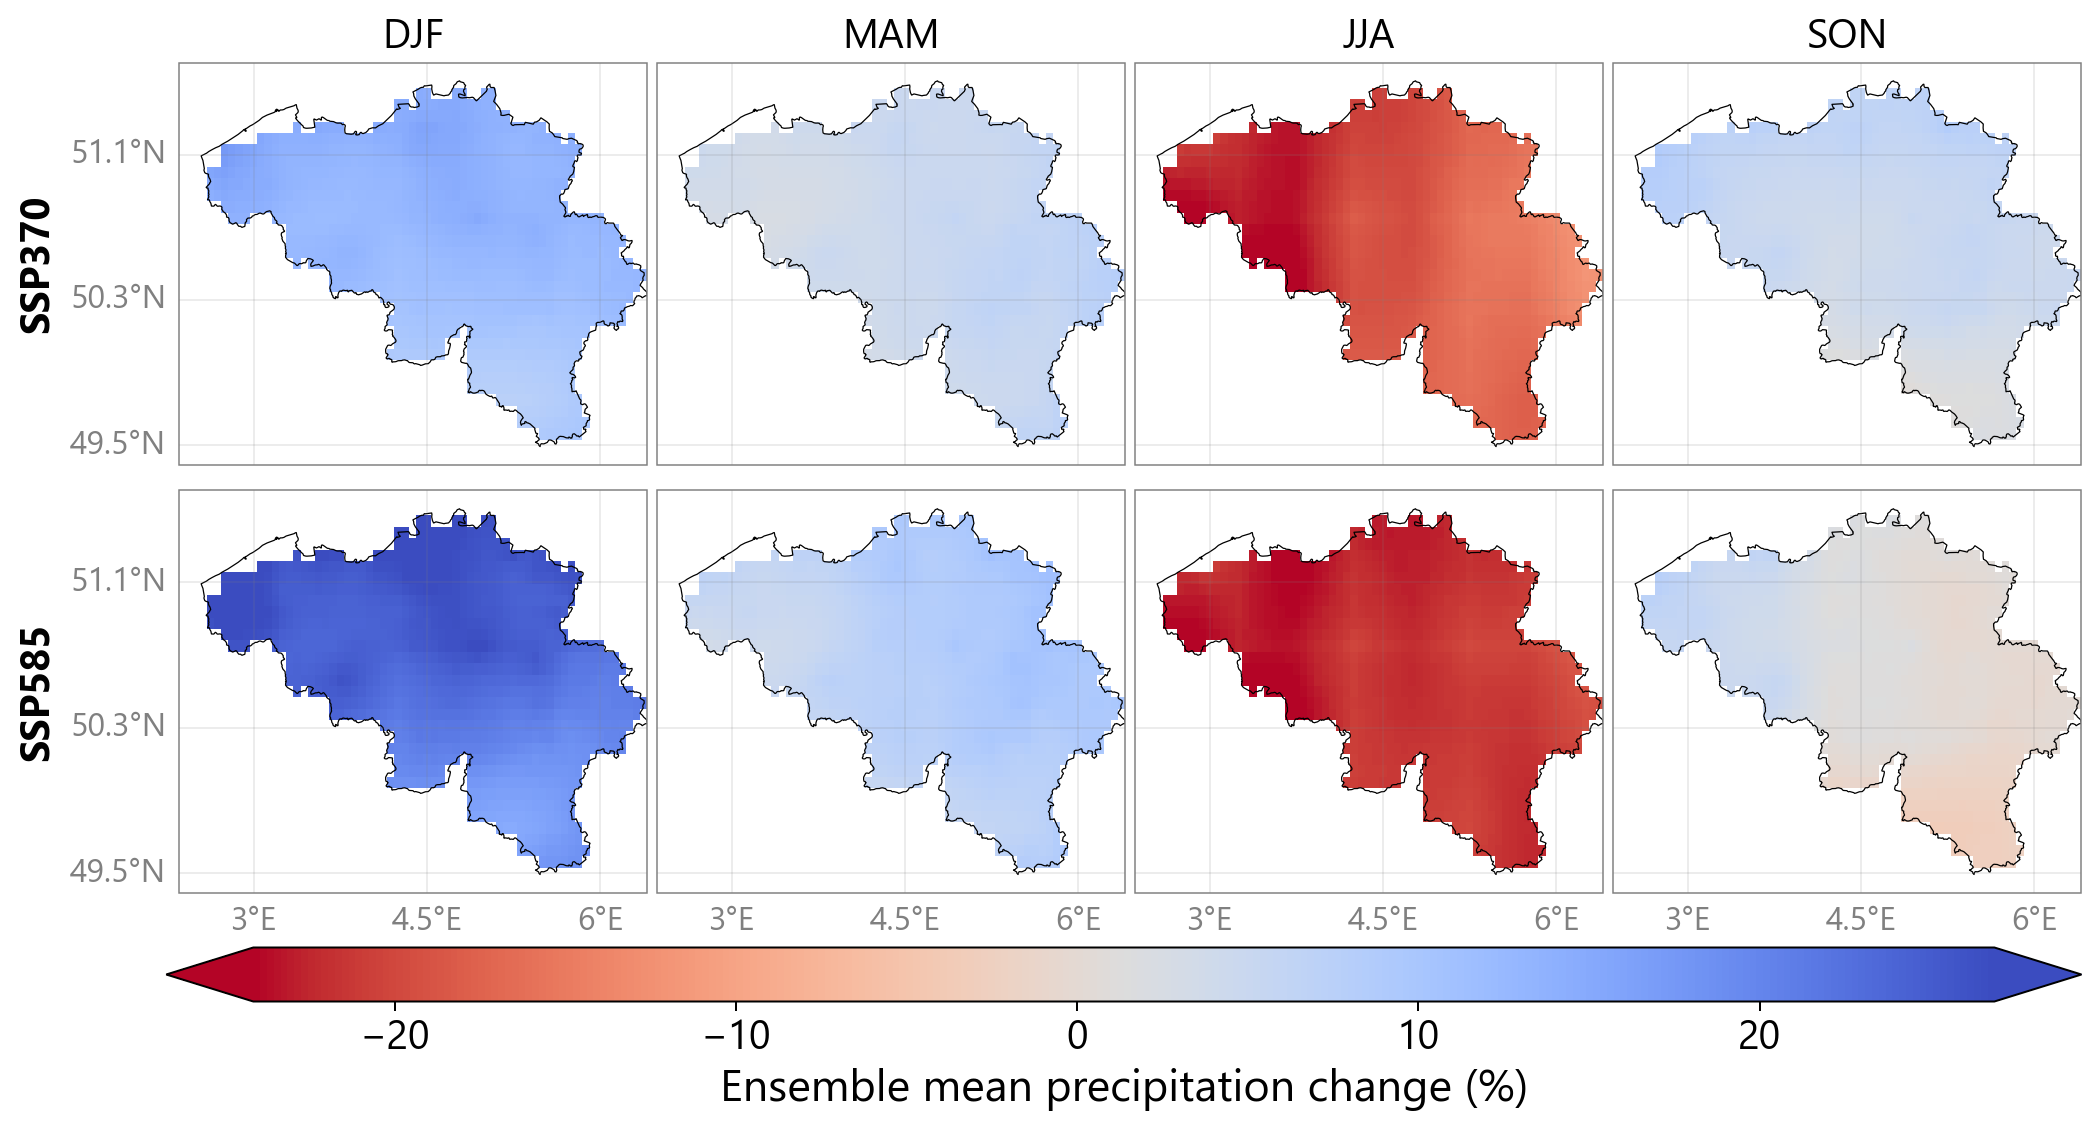

In [70]:
scenarios = ['ssp370', 'ssp585']

fig, axes, cb = plot_ensemble_stats(ensemble_statistics, scenarios,
                                     seasons, 'ens_mean', be_shp,
                                       cmap='coolwarm_r', snr_thresh=0.5) #plasma_r, coolwarm, seismic_r

cb.ax.set_xlabel('Ensemble mean precipitation change (%)', fontsize=18)
#call plt.show()
plt.show()

In [62]:
ensemble_statistics['ssp585']['ens_mean'].groupby('season').mean(dim=['lat', 'lon'])

<xarray.DataArray 'ens_mean' (season: 4)> Size: 16B
array([ 23.091373 ,   7.793437 , -21.93533  ,   1.2126343], dtype=float32)
Coordinates:
  * season       (season) <U3 48B 'DJF' 'MAM' 'JJA' 'SON'
    spatial_ref  int32 4B 0
    time         datetime64[ns] 8B 1981-01-01

#### Internal variability

In [72]:
#===========================SNR internal variability===========================
model_snr_internal = {}
for m in models:
    for scenario in ['ssp370', 'ssp585']:
        ds_hist = hist_ISIMIP[f"{m}_historical_pre"].sel(time=slice(historical_period_start, historical_period_end))['pre']
        ds_fut = isimip_data[f"{m}_{scenario}_pre"].sel(time=slice(future_period_start, future_period_end))['pre']

        # Seasonal totals as a time series (one value per season-year)
        seasonal_hist = ds_hist.resample(time='QS-DEC').sum()
        seasonal_fut  = ds_fut.resample(time='QS-DEC').sum()

        # Group by season to get per-season stats across years
        Hg = seasonal_hist.groupby('time.season')
        Fg = seasonal_fut.groupby('time.season')

        # Per-season interannual mean and std (mm)
        H_mean = Hg.mean('time')                     # dims: season, lat, lon
        F_mean = Fg.mean('time')                     # dims: season, lat, lon
        H_sd   = Hg.std('time', ddof=1)              # year-to-year variability by season
        clim_hist = Hg.mean('time')                # seasonal climatology (mm)

        #Per-season absolute change (mm) and SNR_internal
        delta_abs = F_mean - H_mean                  # dims: season, lat, lon
        eps = 1e-6
        snr_internal = xr.where(H_sd > eps, np.abs(delta_abs) / H_sd, np.nan)
        snr_internal = snr_internal.where(clim_hist > 5)  # mask where season <5 mm

        model_snr_internal[f"{m}_{scenario}_snr_internal"] = snr_internal


#=====================SNR across models========================================
#Calculate ensemble median and SNR across models
ens_scenario_ine_snr = {}
for scenario in ['ssp370', 'ssp585']:
    keys = [f"{m}_{scenario}_snr_internal" for m in models]
    ens = xr.concat([model_snr_internal[k].assign_coords(model=k.split('_')[0]).expand_dims('model') for k in keys], dim='model')

    # Ensemble stats
    ens_mean_imv   = ens.mean('model') #ensemble mean of SNR_internal
    ens_median_imv = ens.median('model')
    ens_std_imv    = ens.std('model', ddof=1)
    n          = ens.sizes['model']
    tcrit      = t.ppf(0.975, df=n-1)
    ci95       = tcrit * ens_std_imv / np.sqrt(n)

    #merge into dataset
    internal_var_xr = xr.Dataset(
        dict(
            ens_mean_imv=ens_mean_imv,
            ens_median_imv=ens_median_imv,
            ens_std_imv=ens_std_imv,
            ci95=ci95,
        ))
    #clip to region
    internal_var_xr = clip_to_region(be_shp, internal_var_xr)

    #save to dictionary
    ens_scenario_ine_snr[scenario] = internal_var_xr

Text(0, 0.5, 'Seasonal internal change uncertainty ')

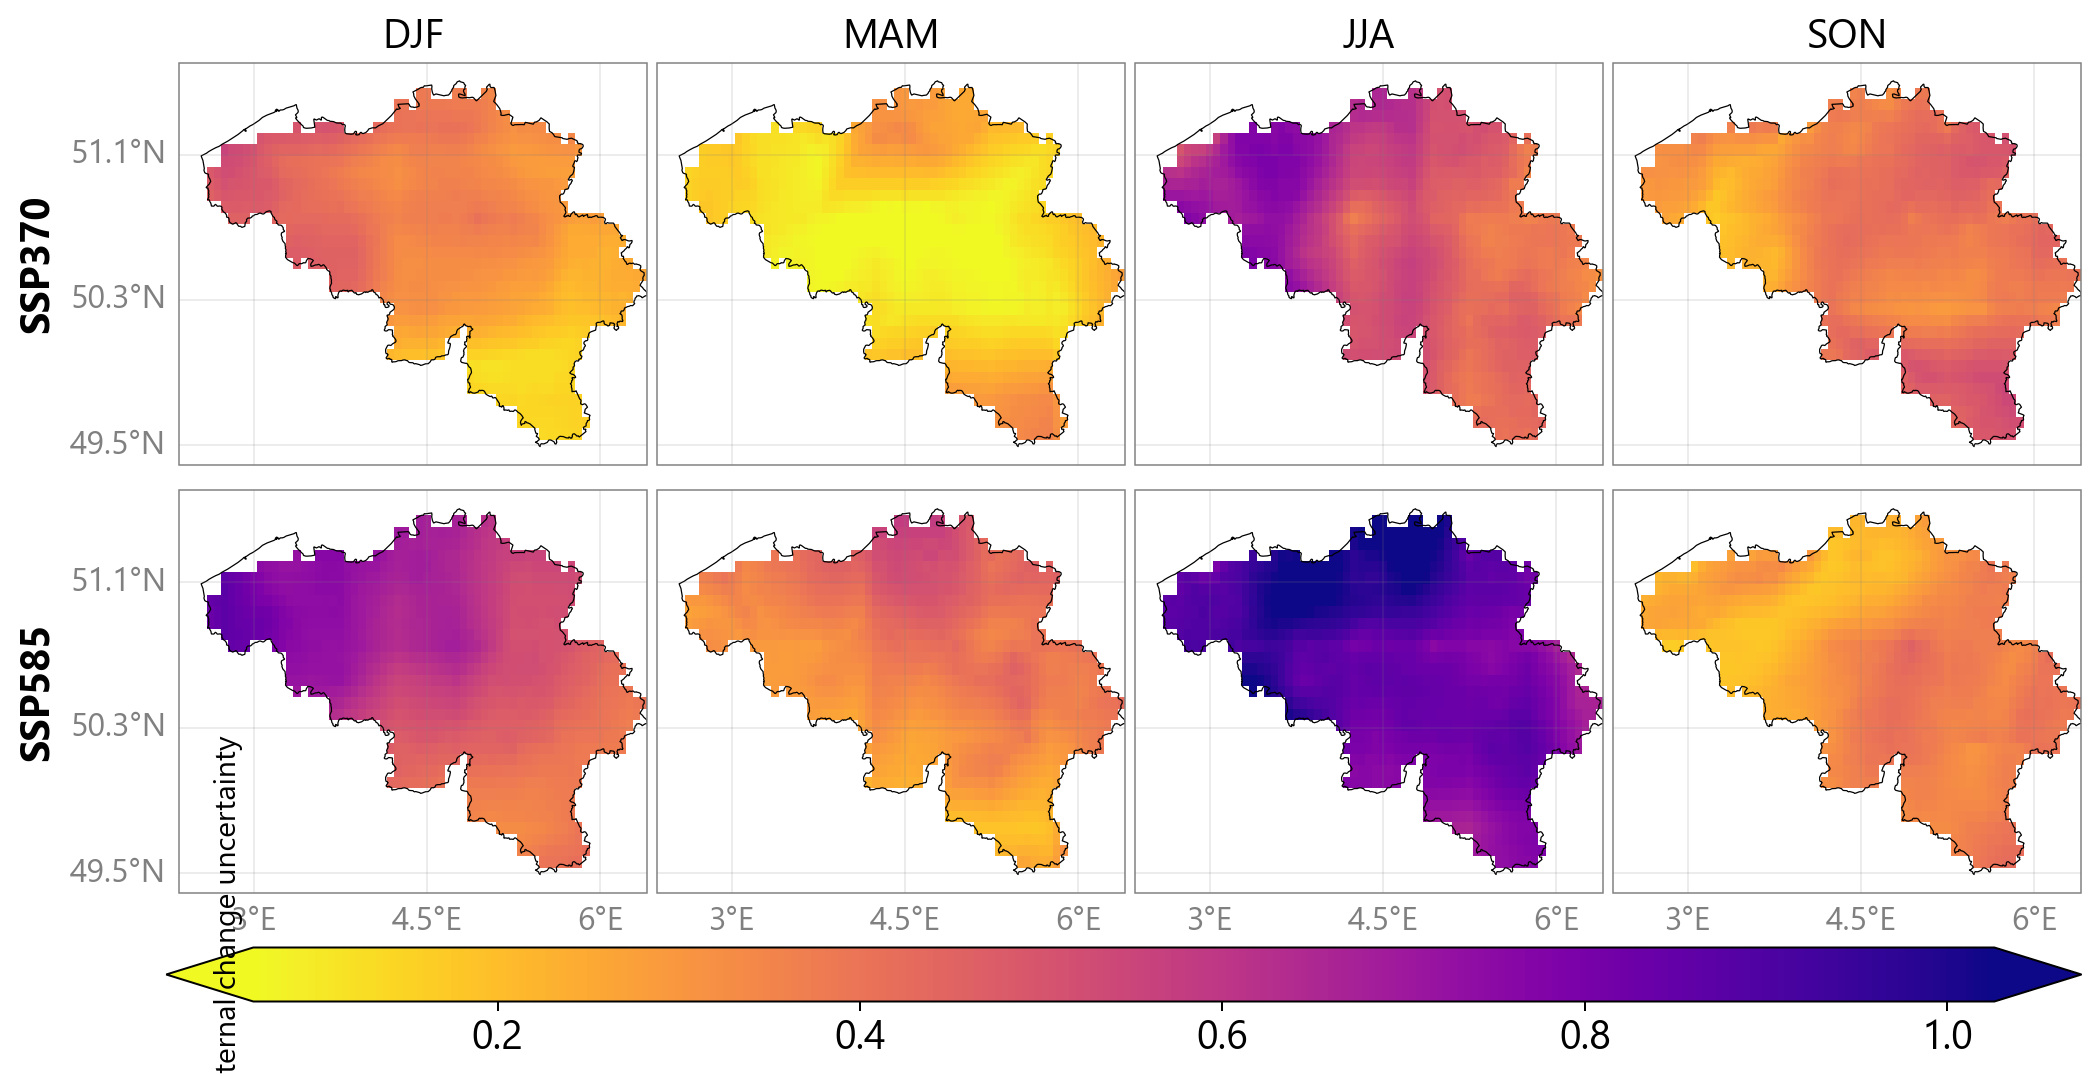

In [73]:
scenarios = ['ssp370', 'ssp585']

fig, axes, cb = plot_ensemble_stats(ens_scenario_ine_snr, scenarios,
                                     seasons, 'ens_median_imv', be_shp,
                                       cmap='plasma_r', snr_thresh=0.0)

cb.ax.set_ylabel('Seasonal internal change uncertainty ', fontsize=12)

#### Projected changes in Temperature

In [17]:
t_vars = ['tmax', 'tmin', 'tavg']

tas_doy = {}

for model in models:
    for scenario in scenarios:
        for variable in t_vars:
            data = isimip_data.get(f"{model}_{scenario}_{variable}")
            data_BE = clip_to_region(be_shp, data).mean(dim=['lon', 'lat'])
            t_df = data_BE.to_dataframe().drop(columns=['spatial_ref'])
            t_df_doy = t_df.groupby(t_df.index.dayofyear).mean()
            tas_doy[f"{model}_{scenario}_{variable}"] = t_df_doy

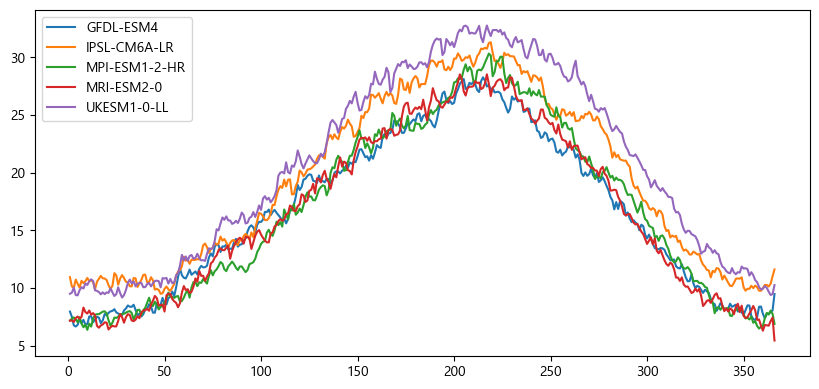

In [18]:
fig, ax = plt.subplots(figsize=(10, 4.5))
for key, df in tas_doy.items():
    if 'ssp585_tmax' in key:
        plt.plot(df.index, df['tmax'], label=key.split('_')[0], linewidth=1.5)
        plt.legend(loc='upper left', fontsize=10)
    if 'historical_tmax' in key:
        plt.plot(df.index, df['tmax'], label=key.split('_')[0], linewidth=1.5, c='gray', alpha=0.5)
        plt.legend(loc='upper left', fontsize=10)
